Load data for I01 (methyleneimmonium)

In [1]:
import xarray as xr

import shnitsel as st
import shnitsel.xarray

xr.set_options(
    display_expand_coords=False,
    display_expand_data_vars=False,
    display_expand_attrs=False,
    display_expand_data=False
)

## Dihedrals for all

In [2]:
from glob import glob
import os

paths = glob('/nc/data/frames_2026-01-12/*')
compounds = {
    name: st.read(path).set_coords(['astate'])
    for path in paths
    if (name:=os.path.split(path)[1].split('_')[0]) not in {'R02a', 'R02b'}
}
compounds

INFO: Identified the path `/nc/data/frames_2026-01-12/I01_ch2nh2.nc` to be of format `shnitsel`.
INFO: State names already assigned
INFO: Identified the path `/nc/data/frames_2026-01-12/A01_ethene.nc` to be of format `shnitsel`.
INFO: State names already assigned
INFO: Identified the path `/nc/data/frames_2026-01-12/A02_propene.nc` to be of format `shnitsel`.
INFO: State names already assigned
INFO: Identified the path `/nc/data/frames_2026-01-12/A03_butene.nc` to be of format `shnitsel`.
INFO: State names already assigned


{'I01': <xarray.Dataset> Size: 13MB
 Dimensions:                (state: 3, frame: 18090, atom: 6, direction: 3,
                             statecomb: 3, full_statecomb: 6, trajid_: 90)
 Coordinates: (25)
 Data variables: (8)
 Attributes: (9),
 'A01': <xarray.Dataset> Size: 126MB
 Dimensions:                (state: 3, frame: 172718, atom: 6, direction: 3,
                             statecomb: 3, full_statecomb: 6, trajid_: 438)
 Coordinates: (27)
 Data variables: (9)
 Attributes: (9),
 'A02': <xarray.Dataset> Size: 167MB
 Dimensions:                (state: 3, frame: 170793, atom: 9, direction: 3,
                             statecomb: 3, full_statecomb: 6, trajid_: 430)
 Coordinates: (27)
 Data variables: (9)
 Attributes: (9),
 'A03': <xarray.Dataset> Size: 69MB
 Dimensions:                (state: 3, frame: 55856, atom: 12, direction: 3,
                             statecomb: 3, full_statecomb: 6, trajid_: 186)
 Coordinates: (25)
 Data variables: (9)
 Attributes: (11)}

In [3]:
d_dihedrals = {
    compound: 
        frames.st.hops([(2, 1)])
        .atXYZ.st.get_bats_matching('[#6,#1][#6]=[#6,#7][#6,#1]', ang='deg', signed=True).isel(descriptor=0)
        .st.expand_midx('frame', 'compound', compound)
    for compound, frames in compounds.items()
}

In [4]:
import xarray as xr
dihedrals = xr.concat(d_dihedrals.values(), dim='frame', coords='different', compat='equals')
dihedrals

<xarray.DataArray 'atXYZ' (frame: 1549)> Size: 6kB
-79.55 -93.1 -50.62 33.02 107.7 -74.64 ... -65.07 90.12 90.69 5.115 62.45 82.11
Coordinates: (15)
Attributes: (5)

In [5]:
dih_df = dihedrals.to_pandas().reset_index().drop(columns=['trajid', 'time'])
dih_df

,compound,atXYZ
0,I01,-79.550705
1,I01,-93.104866
2,I01,-50.622723
3,I01,33.015438
4,I01,107.749741
...,...,...
1544,A03,90.120300
1545,A03,90.689713
1546,A03,5.115310
1547,A03,62.454758


In [6]:
colors = dict(
    st_grey = '#2c3e50',
    st_yellow = '#C4A000',  # (196/255, 160/255, 0/255)
    st_violet = '#7E5273',
    st_blue = '#2233AA',
    st_orange = '#F67E00',
    st_pink = "#E00D99",
)

In [8]:
import matplotlib.pyplot as plt
shnitsel_colors = type(plt.get_cmap('tab10'))(colors.values())

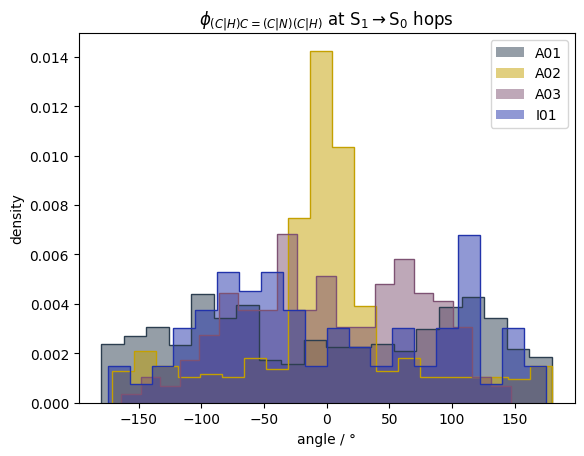

In [9]:
for (name, compound), color in zip(dih_df.groupby('compound'), colors.values()):
    plt.hist(compound['atXYZ'], label=name, color=color, density=True, alpha=.5, bins=20)
    plt.hist(compound['atXYZ'], histtype='step', color=color, density=True, fill=False, bins=20)
plt.legend()
plt.xlabel('angle / °')
plt.ylabel('density')
plt.title(r"$\phi_{(C|H)C=(C|N)(C|H)}$ at S$_1\to$S$_0$ hops")
plt.savefig('/nc/reports/2026-01-13_hop_distributions/all_dihedrals.pdf')

## Pyramidalizations for all

In [10]:
from shnitsel.geo import analogs
combined = analogs.combine_analogs(compounds.values(), '[#6,#1][#6]=[#6,#7]([#1])[#6,#1]', list(compounds))

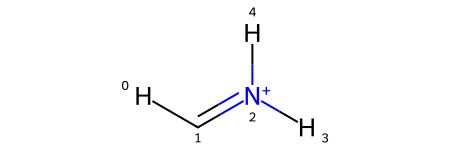

In [11]:
combined.mol

In [30]:
# Pyramidalizations at hops from S2 -> S1
pyr = combined.st.hops([(3, 2)]).atXYZ.st.get_pyramids(deg=True).squeeze('descriptor')
pyr

<xarray.DataArray 'atXYZ' (frame: 209)> Size: 836B
-10.52 -18.54 2.317 -43.68 65.61 6.292 ... 15.24 -5.518 24.16 14.92 -23.52
Coordinates: (12)

In [31]:
pyr_df = pyr.to_pandas().reset_index().drop(columns=['trajid', 'time'])
pyr_df

,compound,atXYZ
0,I01,-10.523047
1,I01,-18.538773
2,I01,2.316821
3,I01,-43.680531
4,I01,65.613777
...,...,...
204,A02,15.244778
205,A02,-5.518048
206,A02,24.157431
207,A02,14.922959


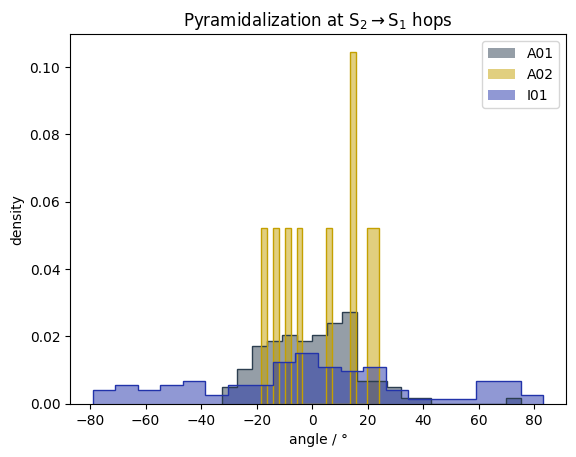

In [45]:
# fig, axs = plt.subplots(2, 1, layout='constrained', sharex=True)
for (name, compound), color in zip(pyr_df.groupby('compound'), colors.values()):
    # ax = axs[0] if name=='A03' else axs[1]
    if name=='A03': continue
    plt.hist(compound['atXYZ'], label=name, color=color, density=True, alpha=.5, bins=20)
    plt.hist(compound['atXYZ'], histtype='step', color=color, density=True, fill=False, bins=20)
plt.legend()
plt.xlabel('angle / °')
plt.ylabel('density')
plt.title(r"Pyramidalization at S$_2\to$S$_1$ hops")
plt.savefig('/nc/reports/2026-01-13_hop_distributions/all_pyramids.pdf')